# Viola Jones (Haar) Face Detection using Python and OpenCV

This is a lab on Viola Jones (a Classical Techniques for Object Classification/Detection) in CE6003. You should complete the tasks in this lab as part of the  Histogram of Oriented Gradients section of the lesson.

Please remember the lab must be completed before taking the quiz at the end of this lesson.

This lab will give some visual intuition on how the classical object classification techniques work. 

A later lab will allow you to compare these techniques, which rely on hand-crafted features and smart algorithms, with their deep learning equivalents, where the features are *learned* by the network as a constituent part of training.

We are going to look at the Viola Jones algorithm from the perspective of performing inference only, not training. That is, we'll take pre-trained classifiers , and use them to classify images of various types. Viola-Jones is blazingly fast, but has obviously accuracy limitations whcih will become apparent when you work through the lab.

Implementing Viola Jones from scratch is outside the scope of this course, but we will look at how it works and leverage OpenCV's implementation for some practical demonstrations.

First, some setup...

First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.

In [284]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git

fatal: destination path 'CE6003' already exists and is not an empty directory.


And now we'll load various Python libraries that we'll need later in this lab...

In [0]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import urllib
 
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
	return image

We also need to install some ancilliary files for OpenCV - this shoud be pretty quick.

In [286]:
!apt install opencv-data

Reading package lists... Done
Building dependency tree       
Reading state information... Done
opencv-data is already the newest version (3.2.0+dfsg-4ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# Viola-Jones and "Haar-like" Features

As you will have seen in our video lectures, Paul Viola and Michael Jones introduced the Viola-Jones technique for finding objects in images in 2001. It is a classical machine learning approach, where a cascade function is trained using a training set of positive and negative images.  For the purpose of explanation, let's assume we're looking for faces in a photo.

Viola-Jones has a number of important concepts, which we'll recap on:
 * Integral Images
 * Adaboost
 * Cascading

The Viola-Jones algorithm typically uses a base patch size (for example, 24x24 pixels) that it slides across and down an image. It evaluates a number of hand-crafted template features within each of these patches to see if the object of interest is present. The types of hand-crafted features (known as *Haar-like Features*) are shown as follows:

![Viola-Jones Features](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/VJ_features.png?raw=1)

These features are equivalent to convolutional kernels. Each feature is evaluated to a single value by subtracting the sum of pixel intensities under the white rectangle from the sum of the pixel intensities under the black rectangle.  These sums of intensities can be computed extremely efficiently, and are responsible for much of the impressive speed of the Viola-Jones algorithm.

Viola-Jones uses a summed area table - essentially a cache of intensity values across an image. The summed area table has the same dimensions as the image of interest. For example, assuming our input image is 640 pixels wide, by 480 pixels high, by 3 channels (RGB), it will first be converted to grayscale (640x480x3 -> 640x480x1). Next, we will construct a summed area table of 640x480x1 where the value at each pixel location in the summed area table is the cumulative sum of itself and each pixel to the left and above it in the image.

![Viola-Jones summed area table calculation](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/ii.gif?raw=1 "Viola-Jones summed area table calculation" )

Once we have the summed area table, we can calculate the sum of intensity values over any arbitrary rectangular patch (an Integral Image) with 4 reads.  Assume that s(X) returns the summed table value for any point X. Now given points A, B, C, and D, then the Integral Image calculation for the rectangular patch defined by ABCD is defined as s(A) + s(D) - s(B) - s(C).

As we end up with more than 160,000 possible features for even a 24x24 patch, it is important to realise that not all features will be equally relevant for a particular type of object. Each feature (essentially a weak classifier) is considered good if it predicts better than chance the presence (or absence) of the desired object.  Viola-Jones uses an algorithm called **Adaboost** to perform *adaptive boosting* of the performance of the cascade of features through a number of iterative rounds. For more details, see our associated video with this module.  Picking the best small set of suitable features helps make the detector super fast. The original Viola-Jones paper achieved 95% accuracy with an appropriately chosen 6,000 feature subset from the 160,000 set of possible features.

However, having to run even 6,000 features on every patch would be a lot of effort. So, once the features have been decided and assembled, we build a cascade of fast rejectors. This is based on the intuition that over a complete image, most of the possible positions we check will not contain a face -- therefore it is faster overall to reject quickly than to invest too much in it. If the location doesn't contain a face, discard it and move on before investing more computational checks in it. This is another of the tricks used by Viola-Jones to achieve its performance. 

![Viola-Jones Cascade of Classifiers](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/VJ_cascade.png?raw=1)

Instead of applying all 6,000 features on a window, we'll group these features into different stages of weak classifiers through the use of Adaboost, and we run these weak classifiers one-by-one in a *Cascade*. If the patch window under consideration fails at any stage, we reject the window and move onto the next patch. Only if a patch window passes one stage of the cascade do we consider moving onto the computation and evaluation of features on the next. A patch which passes all stages is considered a valid detection!

The classifier stages of the cascade are organised in order of increasing number of features, to ensure that early rejections are quick and cheap. In the Viola-Jones paper, the detector had approximately 6,000 features organised into 38 stages - but the first five stages had 1, 10, 25, 25, and 50 features in them respectively. On average, approximately 10 features need to be evaluated per patch in their testing.

Finally, a nice consequence of our features being so quick to calculate (thanks to the Integral Image) leads to the final aspect of Viola-Jones performance.  The base patch itself can be scaled and the features in the final cascade evaluated very quickly to search for objects of different sizes *without* the requirement for an image pyramid. 

(We'll cover the concept of an *image pyramid* in detail when we explore our next technique, the Histogram of Oriented Gradients, but in summary an image pyramid involves rescaling the original image multiple times.  You can think of each slightly smaller image as being stacked upon the previous one vertically, hence the pyramid. As we'll see, scanning across each of these scales repeatedly leads to significant computational cost and effort.)

Putting it all other, the Viola Jones workflow for training looks as follows:

![Viola-Jones - Training Flow](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/viola_jones_flow.png?raw=1)

Let's run some code and see how well the Viola Jones algorithm works. To make it easy for you to experiment, we'll first load our test image into a variable... You can change this subsequently, and rerun the code to play with different images.


Let's load a test image. Feel free to change the URL below to try detecting faces in different URLs pointing to images of people.

In [0]:
# read in test image
#
# We could read in an image directly from our Jupyter Notebook using something like ...
#    test_image = '/content/CE6003/images/lab3/dev290x_presenters.jpg'
#    img = cv2.imread(test_image)
# but it is useful to point to one on the Internet...
test_img = url_to_image("https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/dev290x_presenters.jpg?raw=1")
test_img2 = url_to_image("https://thumbs.dreamstime.com/b/group-people-wearing-sunglasses-29654857.jpg")

We will convert our image to the RGB colorspace used by Jupyter Notebook before plotting, as OpenCV defaults to BGR.

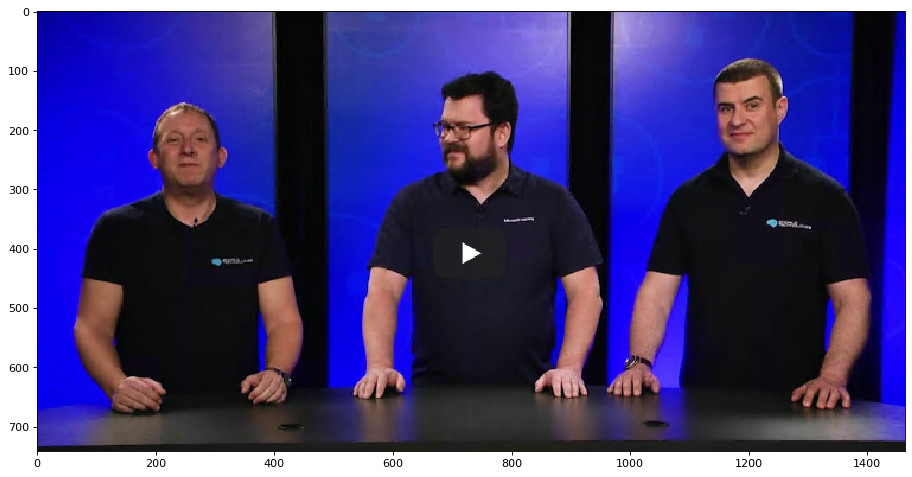

In [288]:
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)
plt.show()

Now, we'll create the cascades with default models that come with OpenCV - one for face detection, and one for eye detection.

These cascade files are XML files which represent the learned Viola-Jones classifier cascades, as described above.

In [0]:
# First, we load the cascades that come by default with OpenCV - one for face detection, and one for eye detection
# we'll find these relative to the CV2 library install

from os.path import realpath, normpath

face_cascade_xml_path = "/usr/share/opencv/haarcascades/haarcascade_frontalface_default.xml"
eye_cascade_xml_path = "/usr/share/opencv/haarcascades/haarcascade_eye.xml"
eyeglass_cascade_xml_path = "/usr/share/opencv4/haarcascades/haarcascade_eye_tree_eyeglasses.xml"
profile_cascade_xml_path = "/usr/share/opencv4/haarcascades/haarcascade_profileface.xml"

face_cascade = cv2.CascadeClassifier(face_cascade_xml_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_xml_path)
eyeglass_cascade = cv2.CascadeClassifier(eyeglass_cascade_xml_path)
profile_cascade = cv2.CascadeClassifier(profile_cascade_xml_path)

# Now lets run the face detector cascade against this grayscale image
scale = 1.03
minNeighbors = 11
foundFaces = face_cascade.detectMultiScale(img, scale, minNeighbors)


The variable `foundFaces` will now contain an array of bounding boxes for each detected face. The number of items in `foundFaces` corresponds to the number of faces detected.
Each element in `foundFaces` is an array of x-position, y-position, width, and height for that particular bounding box.

In [290]:
print ("We found {}".format(len(foundFaces)) + " faces.")
print ("The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:\n{}".format(foundFaces))

We found 3 faces.
The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:
[[1122  112  127  127]
 [ 650  153  115  115]
 [ 195  171  120  120]]


Hopefully, we have now found all the faces in the image using the face detector cascade.  

Our next step is to draw bounding boxes around each of the faces. Then, for each face, we will search within it for eyes, and draw bounding boxes around the eyes in a different color.

In [0]:
# setup colors and line thickness for drawing bounding boxes
greenColor = (0, 255, 0)
blueColor = (255, 0, 0)
lineThickness = 2

detectionsImg = img
# now process each face found, 
for (fx, fy, fw, fh) in foundFaces:
    # draw the bounding box for each face
    cv2.rectangle(detectionsImg, (fx, fy), (fx + fw, fy + fh), blueColor, lineThickness)

    # next we'll run the eye detector cascade on the subset regions of the image (our
    # "regions of interest" (roi)) that were determined to contain faces...
    roi = detectionsImg[fy : fy + fh, fx : fx + fw]
    minEyes=2
    scaleEyes = 1.03
    foundEyes = eye_cascade.detectMultiScale(roi, scaleEyes, minEyes)
    
    # now, lets draw bounding boxes for the eyes
    for (ex, ey, ew, eh) in foundEyes:
        cv2.rectangle(roi, (ex, ey), (ex + ew, ey + eh), greenColor, lineThickness)
        


Finally, lets show off our work by plotting these detections...

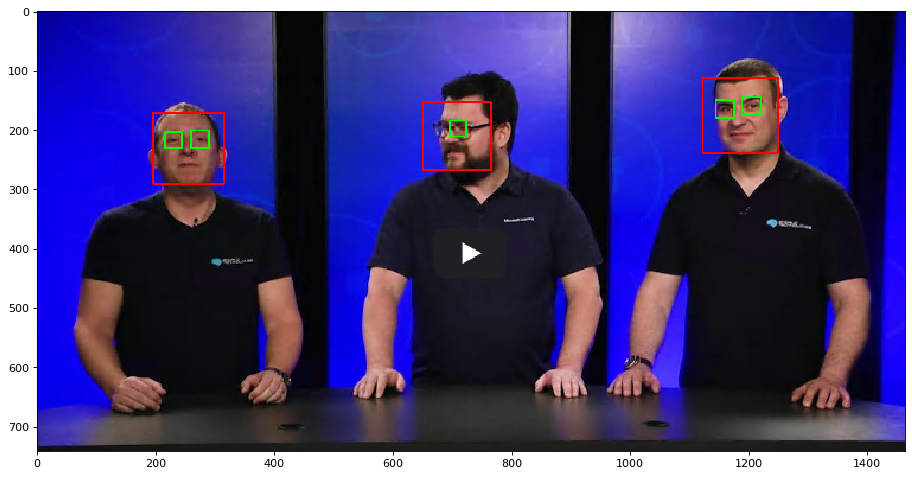

In [292]:
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)
plt.show()

We can see that the detector is pretty good. It has managed to detect all the faces okay, 
but it seems to have found other patches in the image that are very definitely not faces.

Likewise, it has done an okay job at detecting eyes, but it has missed some and invented a few others.

The calls to method `detectMultiScale()` on the cascade objects do the work. `detectMultiScale()` takes three parameters of 
interest, plus some optional parameters that we'll ignore for this exercise.
The three parameters of interest are:
    
* **image**: the image matrix itself.
* **scale**: the scale stride value, indicating how much to resize the features after each run of the detector. 
* **minNeighbors**: a minimum neighbors field, which specifies how many neighbors each candidate detection should have to retain it. 
        
We are using default values of 1.03 for `scale`, and 2 for `minNeighbors`.


**Try playing with these parameters yourself in the code above. For example, set `minNeighbors` to 1, 5, 10, and 100 respectively, rerun the code blocks above related to the Viola-Jones algorithm compare the difference in detections.**

Both the scale and minimum neighbors parameters will affect the quality of the detection. Smaller scale values will cause the detector to check more scalings of the features against the image patch, but will increase the processing time. Likewise, larger values will cause fewer scalings which may result in loss of detections, but will run faster.

Setting the minimum number of allowed neighbors (`minNeighbors`) to a lower value will ensure that recall is good (no missed detections) but is likely to have many false positives. Setting `minNeighbors` to a higher value will improve precision (fewer false positives) but will degrade recall - i.e., there may be false negatives.

Now to work on our new image and try to detect faces wearing glasses:

We will convert our image to the RGB colorspace used by Jupyter Notebook before plotting, as OpenCV defaults to BGR.

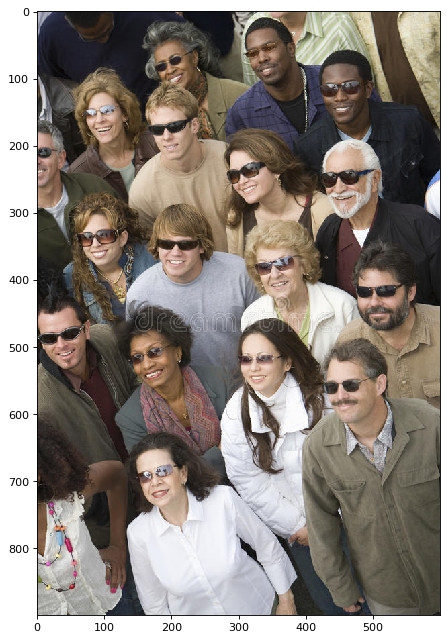

In [293]:
img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img2)
plt.show()

In [0]:
# First, we load the cascades that come by default with OpenCV - one for eyeglass detection
# we'll find these relative to the CV2 library install

face_cascade = cv2.CascadeClassifier(face_cascade_xml_path)
eyeglass_cascade = cv2.CascadeClassifier(eye_cascade_xml_path)
profile_cascade = cv2.CascadeClassifier(profile_cascade_xml_path)

# Now lets run the face detector cascade against this grayscale image
scale = 1.03
minNeighbors = 8

foundFaces = face_cascade.detectMultiScale(img2, scale, minNeighbors)


In [295]:
print ("We found {}".format(len(foundFaces)) + " faces.")
print ("The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:\n{}".format(foundFaces))

We found 15 faces.
The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:
[[300  30  73  73]
 [ 66 128  62  62]
 [154 146  78  78]
 [416  90  75  75]
 [400 213 102 102]
 [ 56 312  66  66]
 [171 321  74  74]
 [315 351  79  79]
 [458 383  94  94]
 [  3 460  69  69]
 [290 492  73  73]
 [121 482  83  83]
 [410 526  88  88]
 [351 607  63  63]
 [139 661  77  77]]


In [0]:
detectionsImg = img2
# now process each face found, 
for (fx, fy, fw, fh) in foundFaces:
    # draw the bounding box for each face
    cv2.rectangle(detectionsImg, (fx, fy), (fx + fw, fy + fh), blueColor, lineThickness)

    # next we'll run the eye detector cascade on the subset regions of the image (our
    # "regions of interest" (roi)) that were determined to contain faces...
    roi = detectionsImg[fy : fy + fh, fx : fx + fw]
    minEyesG=2
    scaleEyesG = 1.02
    foundEyes = eyeglass_cascade.detectMultiScale(roi, scaleEyesG, minEyesG)
    
    # now, lets draw bounding boxes for the eyes
    for (ex, ey, ew, eh) in foundEyes:
        cv2.rectangle(roi, (ex, ey), (ex + ew, ey + eh), greenColor, lineThickness)

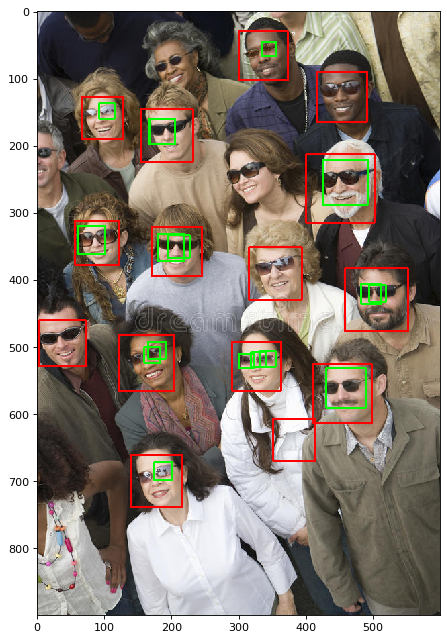

In [297]:
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img2)
plt.show()

# Conclusions

In this lab, we have seen examples of traditional object classification/detection systems, using hand-crafted features with shallow learning algorithms.  We have also seen the need for non-maximal suppression of results during object detection.

Viola-Jones is very fast, and has found much use in detecting faces in images. The main problem is the lack of accuracy. 

HOG is a more accurate detector. Its hand-crafted features detect gradients and gradient magnitudes for blocks of pixels, which is uses to learn characteristic sets of edges for a particular object detector.  However, it can be slow and often requires the use of a full image pyramid to perform detections at different scales.

For many years after its introduction, HOG and its derivative models represented the state of the art in object detection in terms of accuracy.

Over time, researchers incrementally improved the speed of HOG through caching, and the clever adoption of Haar ideas such as cascades of fast rejectors and scaling features not images. Others attempt to add higher semantic layers to HOG by breaking objects into constituent parts (*deformable parts models*) which had hand-crafted spatial relationships with each other. For example, for people detectors, this could include breaking up the person into a head, torso, arms and legs.

When CNNs were (re-)introduced to the problem of image classification with AlexNet in 2012, they were significantly more accurate than the best previous hand-crafted feature detector at the time, and they have continued improving at a faster rate.

In the next tutorial, we'll take a look at Microsoft's ResNet, which is a state of the art deep network for image classification.  We will also discuss the techniques deep nets are currently using to avoid requiring to scan the entire image pyramid, as we do above with the HOG example.
